In [8]:
import gym
import numpy as np
import random
#import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [214]:
env = gym.make('FrozenLake-v0')

In [215]:
env.observation_space.n

16

In [216]:
env.action_space.n

4

In [9]:
tf.reset_default_graph() # what does it really do?

In [10]:

#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32) 

In [13]:
W = tf.Variable(tf.random_uniform([16,4],0,0.01))

In [208]:
W

<tf.Variable 'Variable:0' shape=(16, 4) dtype=float32_ref>

In [20]:
Qout = tf.matmul(inputs1,W)

In [28]:
Qout.shape

TensorShape([Dimension(1), Dimension(4)])

In [22]:
predict = tf.argmax(Qout,1)

In [29]:
#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [146]:
init = tf.initialize_all_variables()

print(env.render())
print("-"*50)
a=env.action_space.sample()
print("Step the random action: {}".format(a))
s1,r,d,v=env.step(a)
print("state(position by index goes upto 16)={}\nreward={}\ndead={}\nval(Probability?)={}".format(s1,r,d,v))
print("-"*50)
print(env.render())

In [202]:
s = env.reset()
s # state at the begining - since this game has a number the state it is 0
#0, Left,1 Down, 2 Right, 3 Up
env.render()


SFFF
FHFH
FFFH
HFFG


In [206]:
s1,r,d,v=env.step(1)
print("state(position by index goes upto 16)={}\nreward={}\ndead={}\nval(Probability?)={}".format(s1,r,d,v))
print("-"*50)
env.render()

state(position by index goes upto 16)=4
reward=0.0
dead=False
val(Probability?)={'prob': 0.3333333333333333}
--------------------------------------------------
  (Down)
SFFF
FHFH
FFFH
HFFG


In [197]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


In [157]:
a=2
s1,r,d,v=env.step(ab)
print("state(position by index goes upto 16)={}\nreward={}\ndead={}\nval(Probability?)={}".format(s1,r,d,v))
print("-"*50)
print(env.render())

state(position by index goes upto 16)=5
reward=0.0
dead=True
val(Probability?)={'prob': 0.3333333333333333}
--------------------------------------------------
  (Right)
SFFF
FHFH
FFFH
HFFG
None


env.step(2)


env.render()

Percent of succesful episodes: 0.0%


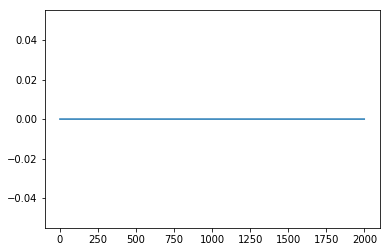

In [213]:
# Set learning parameters
y = .99   # Gamma almost 1.0 - what does this mean? [0,1]
# higher gammma indicates the decision which gives the best reward is given bias (0.99 vs 0.99^2 (for next move and so on))
e = 0.1   # epsilon value - How many times you want to use the predicted (learning NN) than a random input. 1 will mean never use a predicted value. 0 will mean always use the predicted value
# epsilon - selection of random.
num_episodes = 2000 # a large number to stop runaway session (game)
#create lists to contain total rewards and steps per episode
jList = []  # steps in a particular game. i.e. while the game is running how many steps it went through.
rList = []  # reward list - keeping record of rewards on each episode 
with tf.Session() as sess:
    sess.run(init) # call the init function to initialize tensorflow variables.
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset() # start a new game (game.refresh()) s should return state number integer e.g. 0
        rAll = 0        # reward All?
        d = False       # dead is False when it is running
        j = 0          # step counter
        #The Q-Network
        while j < 200:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample() # random movement from the game action space based on epsilon value
            #Get new state and reward from environment
            # env.step returns new state of the game, reward value (since minimization problem it could be 1/score)
            s1,r,d,_ = env.step(a[0]) # same as game.move(a) where a should be  randrange(4)
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]}) # get the next Q table Q(s1,a)
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1) # get the max Q-table value. for this random action 
            targetQ = allQ # target Q table - is zero at the begining of the run.
            targetQ[0,a[0]] = r + y*maxQ1 # equation 1. storing long-term target memory for all the actons done till now.
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ}) # get the weights ignoring other outputs.
            rAll += r # total long-term reward. this means we will never reach zero.
            #print("Episode {}, reward value rAll = {}".format(i,rAll))
            s = s1 
            if d == True:
                #print("Episode {} died after {} steps".format(i,j))
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
            
        jList.append(j)
        rList.append(rAll)
        
num_success=len([v for v in rList if v == 1])
print("Percent of succesful episodes: {}%".format(sum(rList)/num_episodes))

plt.plot(rList)

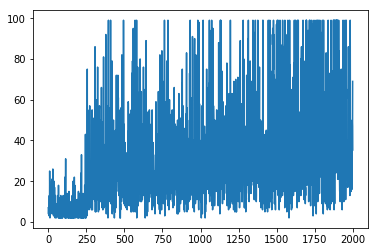

In [152]:
plt.plot(jList)

In [154]:
sum(rList)

903.0

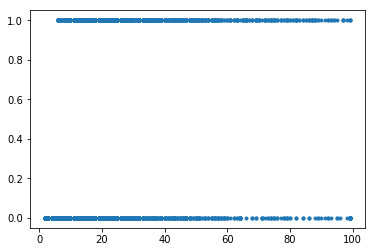

In [212]:
plt.plot(jList,rList,'.')